In [1]:
from pathlib import Path

import ants
import corr
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import sobel
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm


In [2]:
pth = Path("../../data/low_movement/Experiment-746czi")


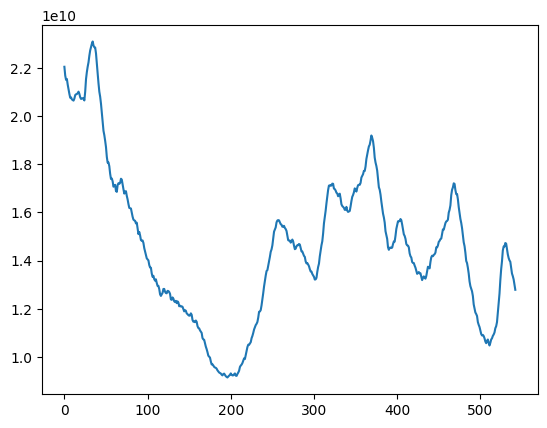

template_index=34


In [3]:
frame_paths = list(pth.glob("frame_*.tif"))
if not frame_paths:
    error_msg = f"No files found matching {pattern}"
    raise FileNotFoundError(error_msg)
frame_paths = [x.as_posix() for x in frame_paths]
frame_paths.sort()
frames = [np.array(Image.open(path)).astype(np.float32) for path in frame_paths]
frames = np.asarray(frames)
template_index = corr.find_highest_correlation(frames, plot=True)
print(f"{template_index=}")


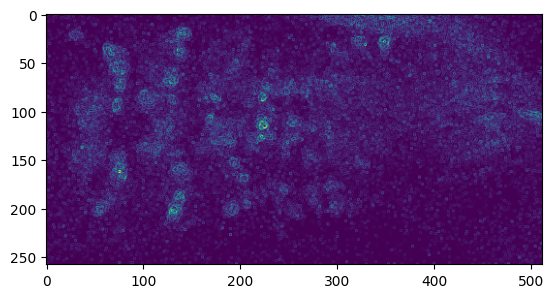

In [5]:
magnitude = corr.get_magnitude(template_float)
plt.imshow(magnitude)

In [ ]:
ants_corrected = corr.ants_reg(frames, template_index)

  2%|█▉                                                                                    | 12/544 [00:09<06:26,  1.38it/s]

In [ ]:
ants_corrected_numpy = []
for image in ants_corrected:
    ants_corrected_numpy.append(image.numpy().astype(np.float32))

In [ ]:
save_path = Path("../data/cache/")
for i, image in enumerate(ants_corrected):
    image = image.astype("float32")
    image.image_write((save_path / f"ants_{i}.tiff").as_posix())

In [ ]:
ants_paths = list(save_path.glob("ants*.tiff"))
ants_paths = [x.as_posix() for x in ants_paths]
ants_paths.sort()
ants_corrected = [ants.image_read(ants_path) for ants_path in ants_paths]

In [ ]:
template = frames[template_index]


In [ ]:
magnitude_template = get_magnitude(template)
plt.imshow(magnitude_template)

In [ ]:
template = frames[template_index]
mean_ssim, mean_gradient_ssim = corr.evaluate(ants_corrected_numpy, template)
print(f"{mean_ssim=}")
print(f"{mean_gradient_ssim=}")

In [ ]:
def evaluate(corrected_images: list, template: np.array):
    ssim_list = []
    for i in tqdm(range(len(corrected_images))):
        ssim_list.append(ssim(template, corrected_images[i],
                            data_range=template.max() - template.min()))
    gradient_ssim_list = []
    gX_template = sobel(template, axis=0)
    gY_template = sobel(template, axis=1)
    magnitude_template = np.sqrt((gX_template**2) + (gY_template**2))
    orientation_template = np.arctan2(gY_template, gX_template) * (180/np.pi) % 180
    data_range_template = magnitude_template.max() - magnitude_template.min()
    for i in range(len(corrected_images)):
        gX = sobel(corrected_images[i], axis=0)
        gY = sobel(corrected_images[i], axis=1)
        magnitude = np.sqrt((gX**2) + (gY**2))
        orientation = np.arctan2(gY, gX) * (180/np.pi) % 180
        gradient_ssim = ssim(magnitude, magnitude_template, data_range=data_range_template)
        gradient_ssim_list.append(gradient_ssim)
    return ssim_list, gradient_ssim_list

In [ ]:
def get_magnitude(img: np.array):
    gX = sobel(img, axis=0)
    gY = sobel(img, axis=1)
    magnitude = np.sqrt((gX**2) + (gY**2))
    return magnitude

In [ ]:
mean_ssim, mean_gradient_ssim = evaluate(ants_corrected_numpy, template)

In [ ]:
magnitude_template = get_magnitude(template)
plt.imshow(magnitude_template)

In [ ]:
plt.imshow(template)

In [ ]:
np.std(mean_ssim)

In [ ]:
np.std(mean_gradient_ssim)

In [ ]:
np.median(mean_ssim)

In [ ]:
np.median(mean_gradient_ssim)